# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [10]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 5.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [12]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Setup
task = Task()
agent = Basic_Agent(task)
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open('data.txt', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done, time = task.step(rotor_speeds)
        to_write = [time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

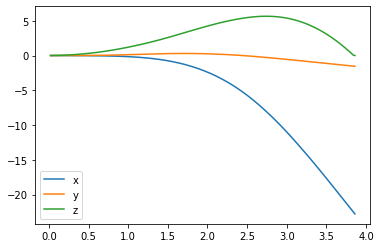

In [14]:
import matplotlib.pyplot as plt
#%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

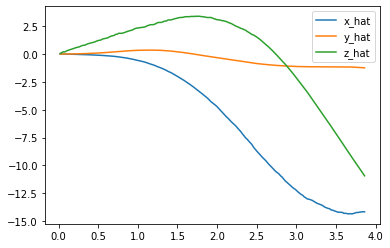

In [15]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

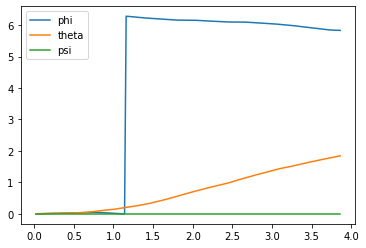

In [16]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

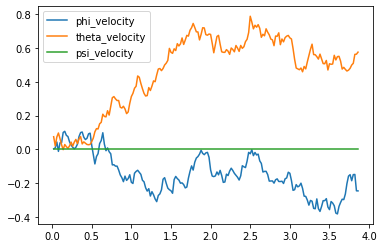

In [17]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

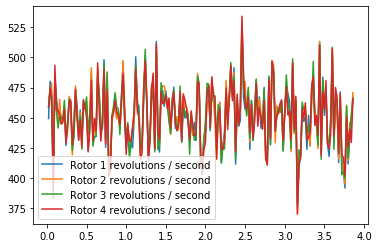

In [18]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [19]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-22.79112077  -1.54520869   0.           5.82984339   1.84724375
   0.        ]
[-14.17168847  -1.23874883 -10.93941616]
[-0.2451252  0.57471    0.       ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [38]:
import sys
import pandas as pd
from policy_search import PolicySearch_Agent
from task import Task

best_score = float('-inf')
results = []
num_episodes = 1000
task = Task()
agent = PolicySearch_Agent(task)

for i in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    score = 0
    while True:
        action = agent.act(state)
        #print(action)
        next_state, reward, done, time = task.step(action)
        agent.step(reward, done)
        score += reward
        state = next_state
        if done:
            best_score = max(best_score, score)
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), end time = {:7.3f}, end x,y,z = {:7.3f},{:7.3f},{:7.3f}".format(
                i, score, best_score, time, state[0], state[1], state[2]), end="")
            break
    results.append(score)
    sys.stdout.flush()

Episode = 1000, score =  12.147 (best = 156.452), end time =   0.240, end x,y,z =  -0.372, -0.502,  0.00000

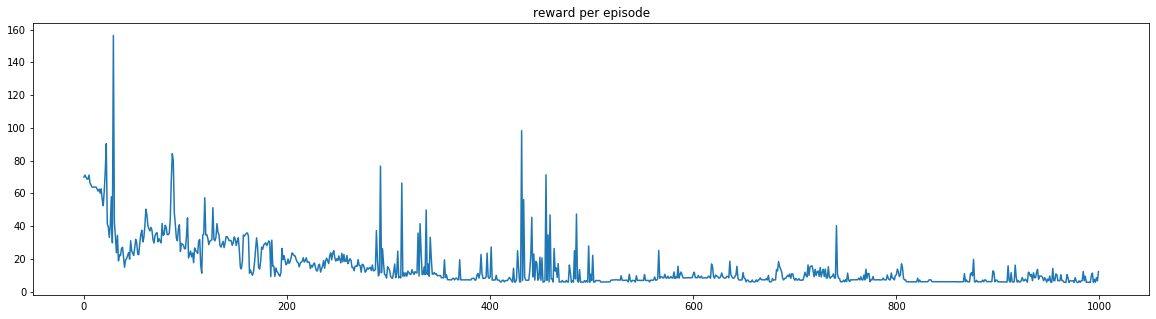

In [39]:
from matplotlib import pyplot

pyplot.figure(figsize=(20,5))
pyplot.plot(range(len(results)), results)
pyplot.title('reward per episode');

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [40]:
# Train my agent
import sys
import pandas as pd
from agent import Agent
from task import Task

results2 = []
best_score = float('-inf')

num_episodes = 1000
task = Task() # use defaults
agent = Agent(task)

for i in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    score = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, time = task.step(action)
        score += reward
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            if score > best_score:
                best_score = score
                agent.save_policy('best.h5')
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), end time = {:7.3f}, end x,y,z = {:7.3f},{:7.3f},{:7.3f}".format(
                i, score, best_score, time, state[0], state[1], state[2]), end="")
            break
    sys.stdout.flush()
    results2.append(score)
agent.save_policy('final.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Episode = 1000, score = 175.789 (best = 263.532), end time =   3.680, end x,y,z = 121.027, 36.666,300.00040

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

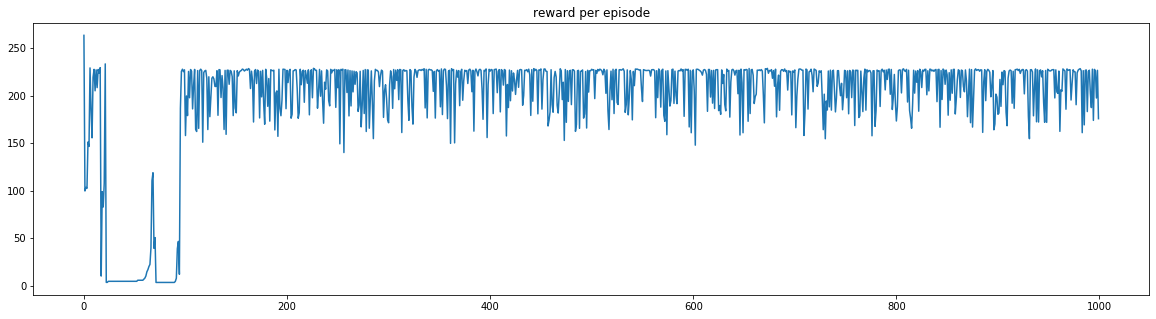

In [41]:
from matplotlib import pyplot

pyplot.figure(figsize=(20,5))
pyplot.plot(range(len(results2)), results2)
pyplot.title('reward per episode');

## Simulate the best run to see what happened

It's really hard to make sense of a score alone, so reload the model parameters associated with the best run and act out that episode.

In [48]:
# I have to see what the final model is doing

# Setup
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3',
          'rotor_speed4', 'reward']
sim = {x : [] for x in labels}

agent.load_policy('best.h5')

# Run the simulation
state = agent.reset_episode()
while True:
    rotor_speeds = agent.act(state, train=False)
    state, reward, done, time = task.step(rotor_speeds)
    metrics = [time] + list(state) + list(rotor_speeds) + [reward]
    for ii in range(len(labels)):
        sim[labels[ii]].append(metrics[ii])
    if done:
        break

final position: -23.00062918974058 31.799507747200412 0.0
sum rewards: 109.99804474744887


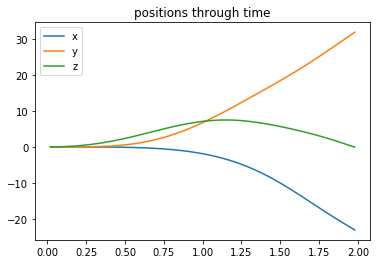

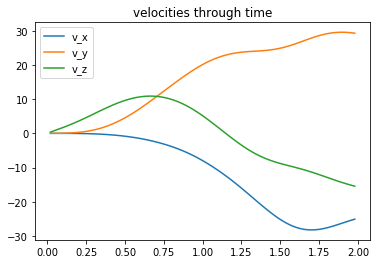

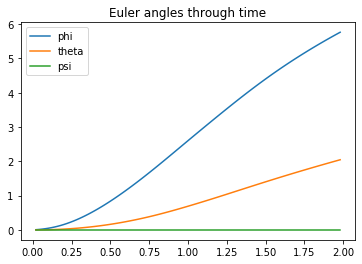

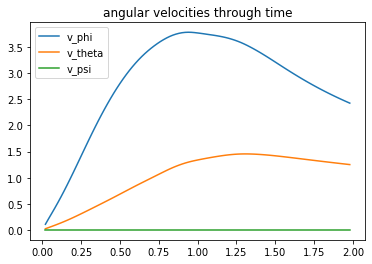

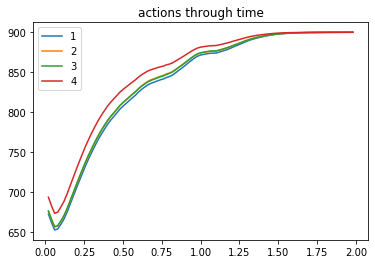

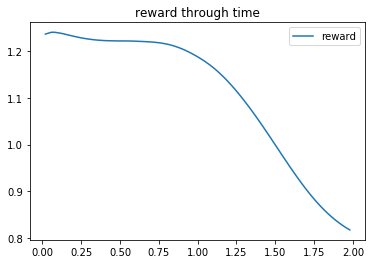

In [49]:
from matplotlib import pyplot

pyplot.figure()
pyplot.plot(sim['time'], sim['x'], label='x')
pyplot.plot(sim['time'], sim['y'], label='y')
pyplot.plot(sim['time'], sim['z'], label='z')
pyplot.legend()
pyplot.title('positions through time')

pyplot.figure()
pyplot.plot(sim['time'], sim['x_velocity'], label='v_x')
pyplot.plot(sim['time'], sim['y_velocity'], label='v_y')
pyplot.plot(sim['time'], sim['z_velocity'], label='v_z')
pyplot.legend()
pyplot.title('velocities through time')

pyplot.figure()
pyplot.plot(sim['time'], sim['phi'], label='phi')
pyplot.plot(sim['time'], sim['theta'], label='theta')
pyplot.plot(sim['time'], sim['psi'], label='psi')
pyplot.legend()
pyplot.title('Euler angles through time')

pyplot.figure()
pyplot.plot(sim['time'], sim['phi_velocity'], label='v_phi')
pyplot.plot(sim['time'], sim['theta_velocity'], label='v_theta')
pyplot.plot(sim['time'], sim['psi_velocity'], label='v_psi')
pyplot.legend()
pyplot.title('angular velocities through time')

pyplot.figure()
pyplot.plot(sim['time'], sim['rotor_speed1'], label='1')
pyplot.plot(sim['time'], sim['rotor_speed2'], label='2')
pyplot.plot(sim['time'], sim['rotor_speed3'], label='3')
pyplot.plot(sim['time'], sim['rotor_speed4'], label='4')
pyplot.legend()
pyplot.title('actions through time')

pyplot.figure()
pyplot.plot(sim['time'], sim['reward'], label='reward')
pyplot.legend()
pyplot.title('reward through time')

print("final position:", sim['x'][-1], sim['y'][-1], sim['z'][-1])
print("sum rewards:", sum(sim['reward']))

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**The Task**: Originally I wanted the quadcopter to take off from the origin at rest and achieve a specific pose with specific velocities. I decided to have it set itself down at (10, 0, 0). After some frustration I decided to ignore the velocities part of the state and care only about position. Still didn't work, largely because it's hard to design a reward function to encode the $z$ dimension in that case: If I just take a standard norm, then I penalize the craft for even lifting off the ground in the first place, so it has to get out of a confusing reward valley.

Eventually settled on having the craft go monotonically from (0,0,0) to (10,3,5).

**Reward**: I was originally penalizing the agent for time spent away from the goal, but this caused it to just learn to go out of bounds as quickly as possible to end the pain. (The actor and critic are modified but not broken; they can learn to do this.)

I tried a sparse reward only at the goal, but this is way too hard.

Then I tried all manner of shaped reward functions. Early on I awarded 100 - penalties for raw distances and forces. This was awful, much too high variance. Probably some exploding gradients somewhere. I tried `tanh` and `max(0, tanh)`. My current reward function consists of 0.5 for staying alive, a radial basis function "hill" centered on the goal location (scaled by 0.5 with a $\sigma$ of 20), and a sum-of-squares penalty on the rotor speeds (scaled by 0.2). It looks like the greatest problem now is uneven thrust betwen the rotors, causing the craft to tip over and fall down or race to the simulation boundary. It is possible some kind of elastic term to keep rotor speeds close to each other could help with this, but I have not tried it.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Algorithm**: I took the provided code and iteratively modified it, trying to get this to work. This is an actor-critic method. I nixed the action-replay stuff because, though I think it makes sense when velocity/time-delta information isn't available, here velocity is available. So my state contains all 12 numerical descriptors of the craft's position and velocity.

Nothing worked best for me, because basically nothing worked: The learning process is pretty unstable, and the quadcopter is unstable too; it often falls down. I know the actor-critic agent is right and can learn, but it gets stuck in local minima, fails catastrophically at certain updates, and generally just doesn't have enough experience on the problem to take meaningful actions before it burns in bad behaviors (like revving up all the rotors to max speed and leaving them there, tipping over, etc.).

**Hyperparameters**: I take $\epsilon$ to mean the noise parameter in Q-learning. I found burn-in was a lot worse with the small noise parameters provided. I changed the Ornstein-Uhlenbeck $\sigma$ to 5, because a variation of 0.5, or even several in a row that happen to build on each other, on a rotor going 900 isn't significant. I tried changing the $\theta$ noise parameter to 0.01 from 0.15 so the noise would "last longer", build on itself more. The effect was unclear, so I changed it back.

I kept $\gamma$ at 0.99, because it's reasonable. $\tau$ of 0.01 seems about right too. Before I understood `soft_update`, I was thinking of loading local parameters into the target ones every hundred iterations or so, and this is doing something on that scale.

$\alpha$ in the RL algorithm is analogous to the learning rates of my networks. I tried making them smaller for stability, but this didn't seem to help anything, probably because the instability is just as much a feature of the physical system we're trying to control. Ultimately left them at the Adam default, which is 0.001.

**Architecture**: There's a great quote [cited in this article](https://www.alexirpan.com/2018/02/14/rl-hard.html) "\[W\]hat we know about good CNN design from supervised learning land doesn’t seem to apply to reinforcement learning land, because you’re mostly bottlenecked by credit assignment/supervision bitrate, not by a lack of a powerful representation. Your ResNets, batchnorms, or very deep networks have no power here."

After some time with this, I firmly agree. It doesn't take that much representative power to encode Q, V, or the Policy. The real issue is that training even a simple net is hard because it's difficult to get enough of the right kind of experience, especially when the experience you do end up getting is dependent upon the training/experience so far. Deep RL is a *Chaotic System* in the Ian Malcolm, John Gall sense.

However, I tried modifying the networks anyway. In particular, I added Batch Normalization and L2 regularization to many of the layers and specially initialized output layers with tiny values, in the hope I wouldn't "hit the rails" (as we say in Electrical Engineering) with wildly enthusiastic or null actions (Policy network), or with extreme positive or negative criticism (Value network). By the end of training, rotors take on somewhat sensible values inside the range \[0,900\], but I can't be sure this is due to my network innovations. (Though they can't hurt.)

Final Q network:

* 128 Dense units with L2 regularization -> batch norm -> ReLU -> 64 Dense units with L2 regularization -> ReLU -> +
* 128 Dense units with L2 regularization -> 64 Dense units with L2 regularization -> +
* \+ -> ReLU -> single Dense output neuron with no activation function initialized with weights uniformly in \[0.005, 0.005\]
* Adam with learning rate 0.001

Final P network:

* 128 Dense units with L2 regularization -> batch norm -> ReLU -> 64 Dense units with L2 regularization -> batch norm -> ReLU -> sigmoid output initialized with weights uniformly in \[0.005, 0.005\] -> scale layer to put outputs in the action range \[0, 900\]
* Adam with learning rate 0.001

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Easy or Hard**: It seems to me this should be a pretty straightforward task, but it's not an easy one because the quadcopter is really unstable and can fail by rotating too much in any of several modes. Reward function design can mitigate some of this, but finding one that does is tedious. I even found myself reading whistfuly about inverse reward design wishing it applied. Finally I found something I think is appropriate, but the agent still has a really difficult time figuring out how to move the quadcopter in the direction of increasing reward without falling. It is learning to slow down and stear, but only well enough to get closer to the goal point and then overshoot. The agent doesn't seem to be making progress toward recognizing that a controlled approach and hover at the goal point would give it more reward than whizzing by and falling.

**Learning Curve**: There don't seem to be any aha moments where score steps up markedly. The agent is stuck in a strategy that isn't very good. In a few other results plots I've observed that catastrophic failures get less catastrophic as Q and P fill in more over training, but that doesn't apply to this one.

**Final performance** is a score of about 100 achieved by shooting from start position past the goal position and falling a full 2 seconds before the 5 second simulation ends.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Hard Parts**:

* At first I didn't realize there was so much example code provided in the lessons post-workspace. So I spent a while enumerating "I need a buffer, I need an Actor network, ...", which was pretty hard, only to find out "Oh, I'll just use this."
* Then trying to figure out exactly what this code is doing and make it my own was hard.
* In particular, I was disappointed that right after being told we can specify the Advantage function with the Value function alone, this implementation is using Q. I banged my head against the problem for a while, carefully combing the code, to see exactly how the Q-function update rules are translated to a loss function and neural network updates. Finally figured it out to my satisfaction, but still didn't dare try to make the code use V instead because I might break it. I know there is a lesson about reducing RL to supervised learning, but these kinds of real details are left out. They should be explained.
* Then running the thing finding "nope, nope, nope, nope" was extremely frustrating. Repeatedly modifying the reward function and hyperparameters and rerunning to see if 50 or so iterations in we were doing any better took ages, and it still isn't clear to me what is going wrong. Making it go right is hard.

**Interesting**: The exploitative suicide behavior was interesting. I'd heard of reward-hacking before, but this was my first hands-on experience with it. Forced me to clarify my thoughts.